In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matspy import spy
import json
from pipeliner.recommendations.transformer import (
    UserItemMatrixTransformer,
    SimilarityTransformer,
)
from pipeliner.recommendations.recommender import SimilarityRecommender

In [19]:
# Create a toy dataset
OVERWRITE = False

NUM_USERS = 12
NUM_ITEMS = 24

# Create arrays for each column
users = np.repeat(np.arange(NUM_USERS), 6)
stacked = np.hstack([np.arange(NUM_ITEMS), np.arange(5)])
strides = np.lib.stride_tricks.sliding_window_view(stacked, 6)[::2]
items = strides.reshape(-1)
ratings = np.tile([0.8, 0.4, 0.6, 0.2, 1.0, 0.8], (12, 1))
rating_bias = np.expand_dims((np.arange(12)/100), 1)
ratings = (ratings + rating_bias).reshape(-1)
ratings = np.clip(ratings, 0.0, 1.0)

print(users.shape, items.shape, ratings.shape)

# Stack arrays to get (user, item, rating) combinations
user_item_ratings_generated = np.column_stack((users, items, ratings)).astype(np.float32)

user_item_ratings_df = pd.DataFrame(
    user_item_ratings_generated, columns=["user_id", "item_id", "rating"]
)
user_item_ratings_df.user_id = user_item_ratings_df.user_id.astype(int).map(
    lambda i: f"U{i + 1:05d}"
)
user_item_ratings_df.item_id = user_item_ratings_df.item_id.astype(int).map(
    lambda i: f"I{i + 1:05d}"
)
if OVERWRITE:
    user_item_ratings_df.to_csv(
        "../../tests/test_data/user_item_ratings_toy.csv", index=False
    )
display(user_item_ratings_df.head(12))

(72,) (72,) (72,)


,user_id,item_id,rating
0,U00001,I00001,0.80
1,U00001,I00002,0.40
2,U00001,I00003,0.60
3,U00001,I00004,0.20
4,U00001,I00005,1.00
5,U00001,I00006,0.80
6,U00002,I00003,0.81
7,U00002,I00004,0.41
8,U00002,I00005,0.61
9,U00002,I00006,0.21


In [20]:
users = user_item_ratings_df.user_id.unique()
items = user_item_ratings_df.item_id.unique()
user_item_matrix_transformer = UserItemMatrixTransformer()
user_item_matrix = user_item_matrix_transformer.transform(
    user_item_ratings_generated
)
user_item_matrix_df = pd.DataFrame(
    user_item_matrix, index=users, columns=items
).astype(np.float32)
user_item_matrix_df.index.name = "user_id"
display(user_item_matrix_df)

if OVERWRITE:
    user_item_matrix_df.to_csv(
        "../../tests/test_data/user_item_matrix_toy.csv", index=True
    )

user_similarity_matrix_transformer = SimilarityTransformer()
user_similarity_matrix = user_similarity_matrix_transformer.transform(user_item_matrix)
user_similarity_matrix_df = pd.DataFrame(
    user_similarity_matrix, index=users, columns=users
).astype(np.float32)
user_similarity_matrix_df.index.name = "user_id"
display(user_similarity_matrix_df)

if OVERWRITE:
    user_similarity_matrix_df.to_csv(
        "../../tests/test_data/user_similarity_matrix_toy.csv", index=True
    )

item_similarity_matrix_transformer = SimilarityTransformer()
item_similarity_matrix = item_similarity_matrix_transformer.transform(
    user_item_matrix.T
)
item_similarity_matrix_df = pd.DataFrame(
    item_similarity_matrix, index=items, columns=items
).astype(np.float32)
item_similarity_matrix_df.index.name = "item_id"
display(item_similarity_matrix_df)

if OVERWRITE:
    item_similarity_matrix_df.to_csv(
        "../../tests/test_data/item_similarity_matrix_toy.csv", index=True
    )

,I00001,I00002,I00003,I00004,I00005,I00006,I00007,I00008,I00009,I00010,...,I00015,I00016,I00017,I00018,I00019,I00020,I00021,I00022,I00023,I00024
user_id,,,,,,,,,,,,,,,,,,,,,
U00001,0.80,0.40,0.60,0.20,1.00,0.80,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
U00002,0.00,0.00,0.81,0.41,0.61,0.21,1.00,0.81,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
U00003,0.00,0.00,0.00,0.00,0.82,0.42,0.62,0.22,1.00,0.82,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
U00004,0.00,0.00,0.00,0.00,0.00,0.00,0.83,0.43,0.63,0.23,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
U00005,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.84,0.44,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
U00006,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
U00007,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.66,0.26,1.00,0.86,0.00,0.00,0.00,0.00,0.00,0.00
U00008,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.87,0.47,0.67,0.27,1.00,0.87,0.00,0.00,0.00,0.00
U00009,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.88,0.48,0.68,0.28,1.00,0.88,0.00,0.00


,U00001,U00002,U00003,U00004,U00005,U00006,U00007,U00008,U00009,U00010,U00011,U00012
user_id,,,,,,,,,,,,
U00001,1.000000,0.469298,0.399111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.370586,0.466426
U00002,0.469298,1.000000,0.474034,0.398892,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.370706
U00003,0.399111,0.474034,1.000000,0.478629,0.398616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
U00004,0.000000,0.398892,0.478629,1.000000,0.483087,0.398286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
U00005,0.000000,0.000000,0.398616,0.483087,1.000000,0.487411,0.397905,0.000000,0.000000,0.000000,0.000000,0.000000
U00006,0.000000,0.000000,0.000000,0.398286,0.487411,1.000000,0.491606,0.397477,0.000000,0.000000,0.000000,0.000000
U00007,0.000000,0.000000,0.000000,0.000000,0.397905,0.491606,1.000000,0.495675,0.397004,0.000000,0.000000,0.000000
U00008,0.000000,0.000000,0.000000,0.000000,0.000000,0.397477,0.495675,1.000000,0.499620,0.396490,0.000000,0.000000
U00009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.397004,0.499620,1.000000,0.503446,0.395937,0.000000


,I00001,I00002,I00003,I00004,I00005,I00006,I00007,I00008,I00009,I00010,...,I00015,I00016,I00017,I00018,I00019,I00020,I00021,I00022,I00023,I00024
item_id,,,,,,,,,,,,,,,,,,,,,
I00001,1.000000,0.952514,0.572359,0.540810,0.382097,0.471175,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.406511,0.324324,0.603794,0.423087
I00002,0.952514,1.000000,0.375152,0.344515,0.270936,0.334099,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.518846,0.413948,0.580200,0.387950
I00003,0.572359,0.375152,1.000000,0.942391,0.538899,0.493570,0.396185,0.489965,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.420939,0.336080
I00004,0.540810,0.344515,0.942391,1.000000,0.309239,0.260624,0.279725,0.345938,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.534312,0.426598
I00005,0.382097,0.270936,0.538899,0.309239,1.000000,0.959376,0.543216,0.500196,0.395505,0.490569,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
I00006,0.471175,0.334099,0.493570,0.260624,0.959376,1.000000,0.352177,0.300058,0.312252,0.387305,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
I00007,0.000000,0.000000,0.396185,0.279725,0.543216,0.352177,1.000000,0.959765,0.547406,0.506639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
I00008,0.000000,0.000000,0.489965,0.345938,0.500196,0.300058,0.959765,1.000000,0.358985,0.308950,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
I00009,0.000000,0.000000,0.000000,0.000000,0.395505,0.312252,0.547406,0.358985,1.000000,0.960100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


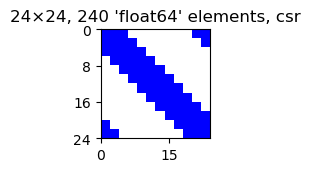

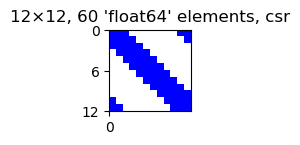

In [21]:
spy(sp.sparse.csr_matrix(item_similarity_matrix))
spy(sp.sparse.csr_matrix(user_similarity_matrix))

In [22]:
item_ids = user_item_matrix_df.columns

item_encoder = LabelEncoder()
item_ids_encoded = item_encoder.fit_transform(item_ids)

similarity_rec = SimilarityRecommender(10)
similarity_rec.fit(item_similarity_matrix)
item_recs = similarity_rec.recommend(item_ids_encoded)

results = [item_encoder.inverse_transform(item).tolist() for item in item_recs]
similarity_recommendations_toy = {item_id: result for item_id, result in zip(item_ids, results)}

if OVERWRITE:
    with open("../../tests/test_data/similarity_recommendations_toy.json", "w") as f:
        f.write(json.dumps(similarity_recommendations_toy, indent=4))

    item_probs = similarity_rec.predict_proba(item_ids_encoded).toarray().astype(np.float32).round(6)
    np.save("../../tests/test_data/similarity_recommendations_toy_probs.npy", item_probs)